## FOOD classification
-------------------


### The goal of this project is to classify food into 11 categories . We will start with a simple model than do improvements to get the best score.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive

# mount your Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import tensorflow as tf
import os
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16

from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from os import listdir
from os.path import isdir, isfile, join
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Getting the data from kaggle
# https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [ ]:
os.environ['KAGGLE_USERNAME']='xx'

In [ ]:
os.environ['KAGGLE_KEY']='1337437'

In [ ]:
!kaggle datasets download -d trolukovich/food11-image-dataset

100% 1.08G/1.08G [00:54<00:00, 24.2MB/s]
100% 1.08G/1.08G [00:54<00:00, 21.3MB/s]


In [ ]:
#uploading the data

from zipfile import ZipFile

file_name='/content/food11-image-dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [ ]:
TRAIN_DATA_DIR = "/content/training"
TEST_DATA_DIR = "/content/validation"
VAL_DATA_DIR = "/content/evaluation"

In [ ]:
CLASSES = sorted(listdir(TRAIN_DATA_DIR))
CLASSES

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(128, 128),
    batch_size=32,
    classes=CLASSES,
    class_mode='categorical'
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR, 
    classes=CLASSES,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


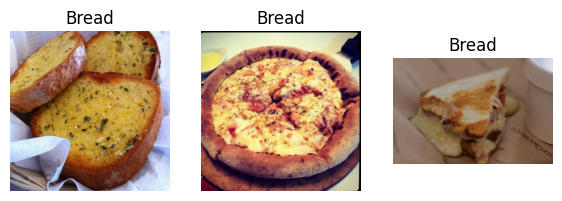

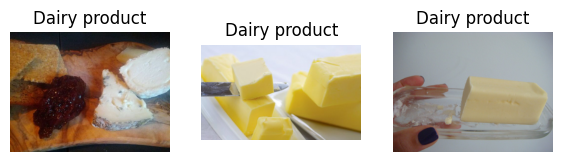

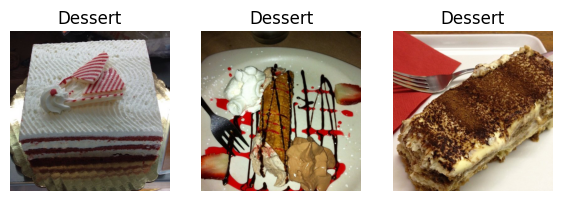

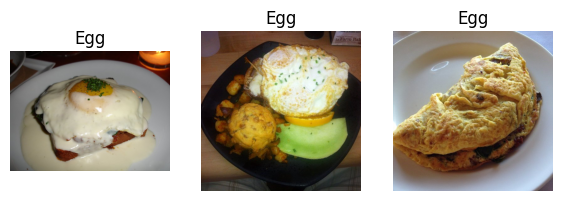

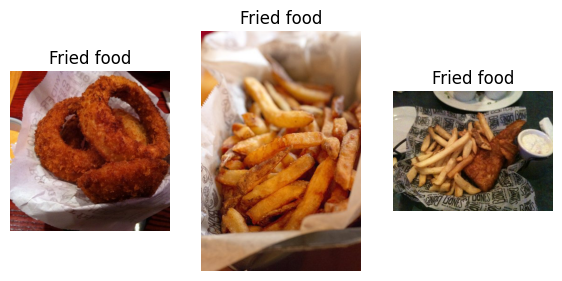

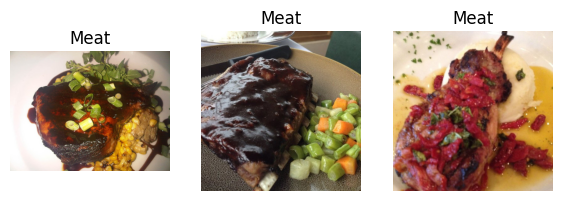

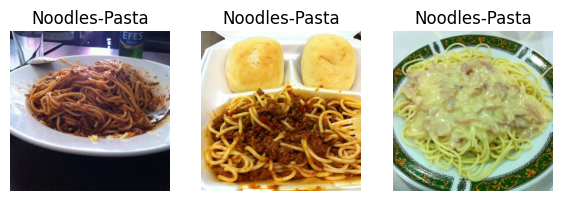

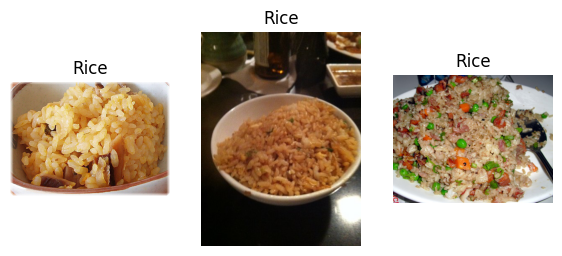

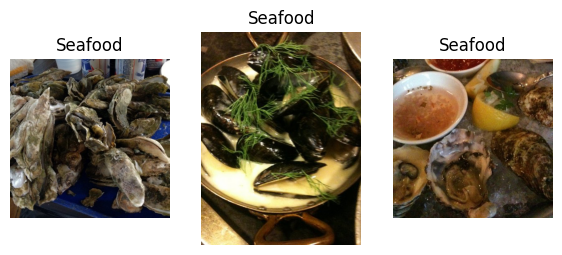

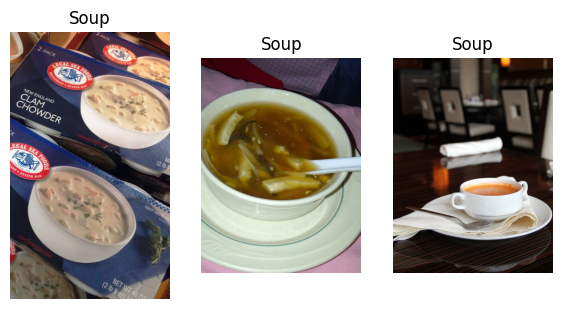

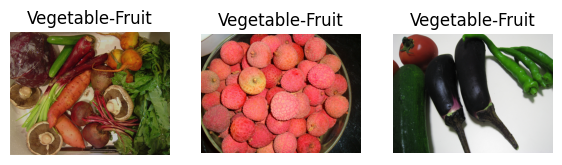

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the number of images to display from each category
num_images = 3

# Get the class indices from the generator
class_indices = train_generator.class_indices

# Invert the class indices to get the class labels
class_labels = {v: k for k, v in class_indices.items()}

# Get the filenames and labels for all the images in the generator
filenames = train_generator.filenames
labels = train_generator.labels

# Loop through each class
for class_idx, class_label in class_labels.items():

    # Get the indices of the images in the class
    indices = np.where(labels == class_idx)[0]

    # Get the first `num_images` indices from the class
    indices = indices[:num_images]

    # Get the filenames and labels for the selected images
    class_filenames = [filenames[i] for i in indices]
    class_labels = [class_label for i in range(num_images)]

    # Load and display the images
    images = [plt.imread(os.path.join(train_generator.directory, filename)) for filename in class_filenames]

    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(7, 7))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title(class_labels[i])
    plt.show()


In [ ]:
sample_batch = next(train_generator)

sample_batch[0].shape

(32, 128, 128, 3)

## Simple cnn model

In [ ]:
model = tf.keras.models.Sequential([

    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=sample_batch[0].shape[1:]),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(11, activation='softmax')

])

In [ ]:
model.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [ ]:
## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
BATCH_SIZE=32
history = model.fit(
    train_generator, 
    epochs=50, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stop],
    verbose=True
)

Epoch 1/50
308/308 [==============================] - 141s 435ms/step - loss: 2.1711 - accuracy: 0.2230 - val_loss: 1.9283 - val_accuracy: 0.3278
Epoch 2/50
308/308 [==============================] - 110s 357ms/step - loss: 1.9170 - accuracy: 0.3265 - val_loss: 1.7619 - val_accuracy: 0.3939
Epoch 3/50
308/308 [==============================] - 134s 435ms/step - loss: 1.7930 - accuracy: 0.3672 - val_loss: 1.8226 - val_accuracy: 0.3933
Epoch 4/50
308/308 [==============================] - 112s 362ms/step - loss: 1.6842 - accuracy: 0.4063 - val_loss: 1.6004 - val_accuracy: 0.4438
Epoch 5/50
308/308 [==============================] - 110s 356ms/step - loss: 1.5956 - accuracy: 0.4425 - val_loss: 1.7165 - val_accuracy: 0.4198
Epoch 6/50
308/308 [==============================] - 110s 357ms/step - loss: 1.5221 - accuracy: 0.4675 - val_loss: 1.4994 - val_accuracy: 0.4841
Epoch 7/50
308/308 [==============================] - 111s 362ms/step - loss: 1.4437 - accuracy: 0.4921 - val_loss: 1.4891 -

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

105/105 [==============================] - 21s 202ms/step - loss: 1.3230 - accuracy: 0.5748
Loss: 1.3230289220809937
Accuracy: 0.574843168258667


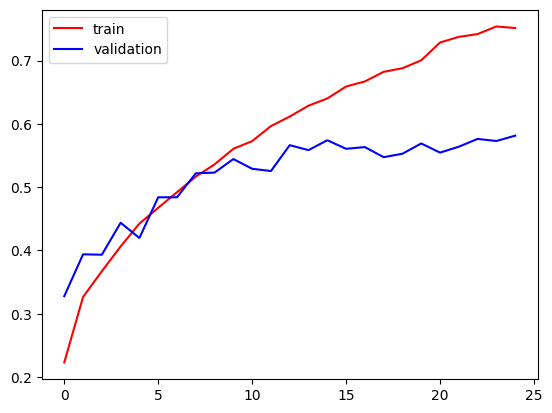

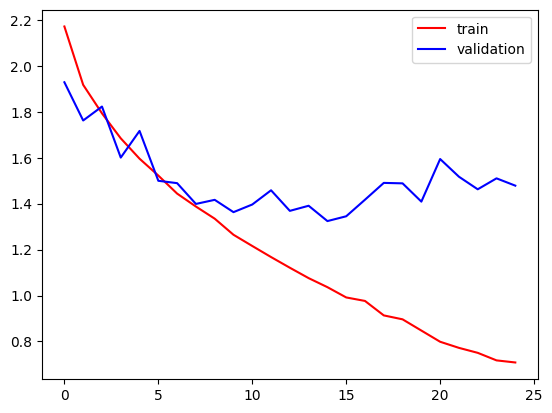

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()
     

In [ ]:
# save the model file to your Google Drive
model.save('/content/gdrive/My Drive/model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model.h5')

We have a difference between test accuracy and train accuracy so our model is overfitting

To try to fix this problem we can try to add dropout layers

## MODEL WITH DROPOUT

In [ ]:
model_2_with_dropout = tf.keras.models.Sequential([

    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=sample_batch[0].shape[1:]),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),

    tf.keras.layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(11, activation='softmax')

])

In [ ]:
model_2_with_dropout.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [ ]:
model_2_with_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 256)       295168    
                                                      

In [ ]:
## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='min')
BATCH_SIZE=32
history = model_2_with_dropout.fit(
    train_generator, 
    epochs=50, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stop],
    verbose=True
)

Epoch 1/50
308/308 [==============================] - 127s 390ms/step - loss: 2.2280 - accuracy: 0.1978 - val_loss: 2.1251 - val_accuracy: 0.2314
Epoch 2/50
308/308 [==============================] - 115s 374ms/step - loss: 2.0602 - accuracy: 0.2735 - val_loss: 1.9893 - val_accuracy: 0.3047
Epoch 3/50
308/308 [==============================] - 136s 443ms/step - loss: 1.9441 - accuracy: 0.3151 - val_loss: 1.8436 - val_accuracy: 0.3546
Epoch 4/50
308/308 [==============================] - 115s 374ms/step - loss: 1.8732 - accuracy: 0.3426 - val_loss: 1.7729 - val_accuracy: 0.3957
Epoch 5/50
308/308 [==============================] - 137s 443ms/step - loss: 1.8175 - accuracy: 0.3698 - val_loss: 1.7187 - val_accuracy: 0.4123
Epoch 6/50
308/308 [==============================] - 116s 378ms/step - loss: 1.7419 - accuracy: 0.3897 - val_loss: 1.6976 - val_accuracy: 0.4111
Epoch 7/50
308/308 [==============================] - 116s 376ms/step - loss: 1.6842 - accuracy: 0.4154 - val_loss: 1.5971 -

In [ ]:
loss, accuracy = model_2_with_dropout.evaluate(test_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

105/105 [==============================] - 23s 220ms/step - loss: 1.2494 - accuracy: 0.5760
Loss: 1.2493730783462524
Accuracy: 0.5760382413864136


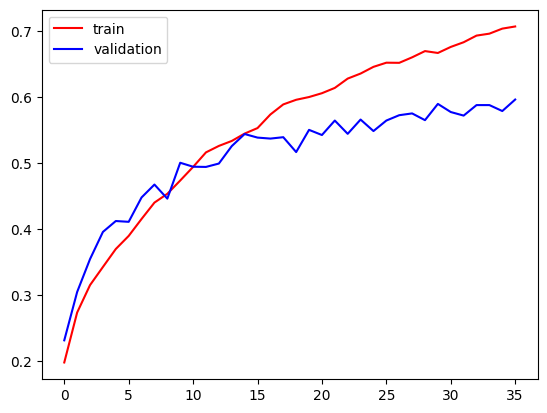

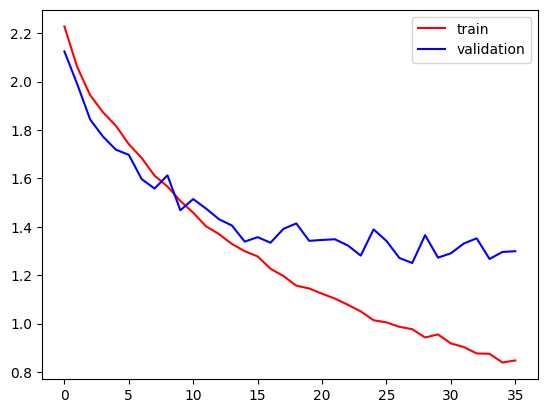

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()
     

In [ ]:
# save the model file to your Google Drive
model_2_with_dropout.save('/content/gdrive/My Drive/model_2_with_dropout.h5')

Its better than before but still overfitting

We can  try to do data augmentation to get better results

## DATA AUGMENTATION

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128,128,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.3),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

In [ ]:
model_a = Sequential([data_augmentation,model])


In [ ]:
model_a.compile(loss = 'CategoricalCrossentropy',optimizer='adam', metrics = ['accuracy'])

In [ ]:
early_stop=EarlyStopping(monitor= 'val_loss',patience=5,restore_best_weights=True,mode='min')

In [ ]:
BATCH_SIZE=32
model_a.fit(train_generator,epochs=20,
            steps_per_epoch=train_generator.samples//BATCH_SIZE,
            validation_data=test_generator,
            validation_steps=test_generator.samples//BATCH_SIZE,
            callbacks=early_stop)

Epoch 1/20
308/308 [==============================] - 119s 385ms/step - loss: 1.3870 - accuracy: 0.5124 - val_loss: 1.8555 - val_accuracy: 0.4531
Epoch 2/20
308/308 [==============================] - 112s 364ms/step - loss: 1.3409 - accuracy: 0.5346 - val_loss: 1.7402 - val_accuracy: 0.4823
Epoch 3/20
308/308 [==============================] - 113s 368ms/step - loss: 1.3074 - accuracy: 0.5469 - val_loss: 1.7916 - val_accuracy: 0.4585
Epoch 4/20
308/308 [==============================] - 115s 372ms/step - loss: 1.2906 - accuracy: 0.5450 - val_loss: 1.6836 - val_accuracy: 0.4627
Epoch 5/20
308/308 [==============================] - 135s 437ms/step - loss: 1.2714 - accuracy: 0.5530 - val_loss: 2.2313 - val_accuracy: 0.4252
Epoch 6/20
308/308 [==============================] - 114s 369ms/step - loss: 1.2516 - accuracy: 0.5602 - val_loss: 1.9189 - val_accuracy: 0.4501
Epoch 7/20
308/308 [==============================] - 137s 446ms/step - loss: 1.2209 - accuracy: 0.5746 - val_loss: 1.7084 -

In [ ]:
loss, accuracy = model_a.evaluate(test_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

105/105 [==============================] - 20s 193ms/step - loss: 1.9141 - accuracy: 0.4721
Loss: 1.9140827655792236
Accuracy: 0.4720645248889923


Our mode is  still performing  poorly especially on test set

## Hyper parameter tuning

We can do hyper parameter tuning using keras tuner

In [ ]:
pip install -U keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.9 MB/s eta 0:00:00


In [ ]:
final_data = []
final_labels = []

for i in range(0,len(train_generator)):
    batch = train_generator[i]
    for j in range(len(batch[0])):
        final_data.append(batch[0][j])
        final_labels.append(batch[1][j])

val_data = []
val_labels = []

for i in range(0,len(test_generator)):
    batch = test_generator[i]
    for j in range(len(batch[0])):
        val_data.append(batch[0][j])
        val_labels.append(batch[1][j])
        
final_data = np.array(final_data)
final_labels = np.array(final_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)

### HYPER PARAMETER TUNING FOR DATA AUGMENTATION

In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential([data_augmentation])  #adding the data augmentation to the keras sequential
    model.add(keras.layers.AveragePooling2D(4,2))
    
    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
        model.add(keras.layers.MaxPool2D((3,3)))

    model.add(keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides = 1,padding = 'same',activation = 'relu'))
    model.add(keras.layers.Conv2D(filters = 64,kernel_size=(3,3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256]), activation='relu'))

    model.add(keras.layers.Dense(11, activation='softmax'))

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
)

tuner.search(final_data, final_labels, validation_data=(val_data, val_labels), epochs=80)

Trial 10 Complete [00h 07m 28s]
val_loss: 0.18343493342399597

Best val_loss So Far: 0.17622725665569305
Total elapsed time: 00h 48m 15s


In [ ]:
hp_augm = tuner.get_best_models()[0]

In [ ]:
loss, accuracy = hp_augm.evaluate(test_generator)

print("LOSS", loss)
print("ACCURACY", accuracy)

105/105 [==============================] - 26s 246ms/step - loss: 0.1762 - accuracy: 0.5967
LOSS 0.17622725665569305
ACCURACY 0.5966536998748779


We got a better accuracy on the test test

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input


### Since it's a hard dataset with 11 categories and each category have different images the best thing to do is use prebuilt models

## Transfer Learning

### VGG16

This model is without data augmentation

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
x = Flatten()(vgg16.output)    
prediction = Dense(11, activation='softmax')(x)


In [ ]:
# create a model object
model5 = Model(inputs=vgg16.input, outputs=prediction)
model5.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
r = model5.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=15,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator)
)

Epoch 1/15
309/309 [==============================] - 192s 618ms/step - loss: 21.0632 - accuracy: 0.5288 - val_loss: 3.3199 - val_accuracy: 0.3463
Epoch 2/15
309/309 [==============================] - 186s 601ms/step - loss: 21.8572 - accuracy: 0.6150 - val_loss: 4.7691 - val_accuracy: 0.2563
Epoch 3/15
309/309 [==============================] - 187s 605ms/step - loss: 22.7855 - accuracy: 0.6480 - val_loss: 4.5888 - val_accuracy: 0.2611
Epoch 4/15
309/309 [==============================] - 196s 635ms/step - loss: 22.4221 - accuracy: 0.6666 - val_loss: 6.2648 - val_accuracy: 0.2904
Epoch 5/15
309/309 [==============================] - 188s 609ms/step - loss: 24.0020 - accuracy: 0.6826 - val_loss: 6.5225 - val_accuracy: 0.2584
Epoch 6/15
309/309 [==============================] - 185s 600ms/step - loss: 24.5806 - accuracy: 0.6823 - val_loss: 7.9893 - val_accuracy: 0.2504
Epoch 7/15
309/309 [==============================] - 187s 605ms/step - loss: 24.8610 - accuracy: 0.6894 - val_loss: 7

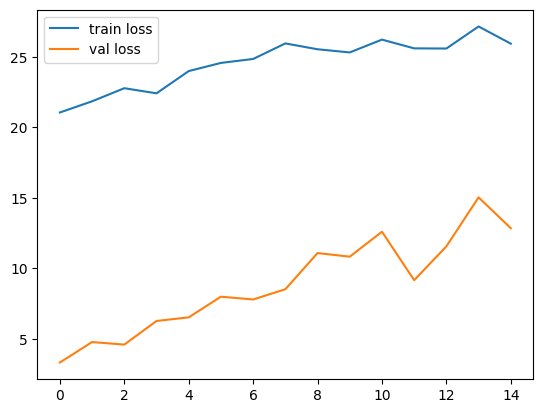

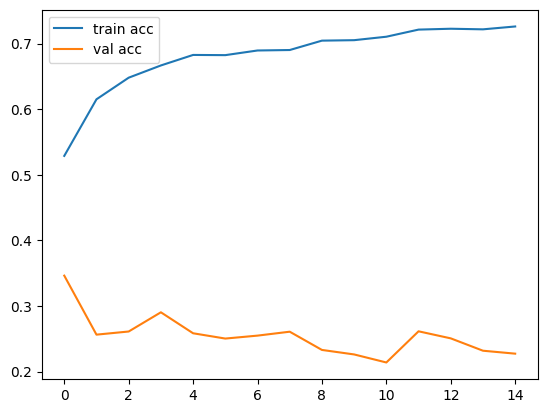

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

We got a very bad performance too much overfitting

## InceptionNet

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(250, 250),
    batch_size=32,
    classes=CLASSES,
    class_mode='categorical'
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR, 
    classes=CLASSES,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

Inception Net without data augmetatio

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model3 = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
model3.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs = 15

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_incept.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,verbose=1)
]
BATCH_SIZE=32
history = model3.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=test_generator,
        verbose = 1,
        validation_steps=test_generator.samples // BATCH_SIZE)

Epoch 1/15
308/308 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.7391
Epoch 1: val_loss improved from inf to 0.60424, saving model to model_incept.h5
308/308 [==============================] - 144s 424ms/step - loss: 0.8920 - accuracy: 0.7391 - val_loss: 0.6042 - val_accuracy: 0.8029
Epoch 2/15
308/308 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8701
Epoch 2: val_loss did not improve from 0.60424
308/308 [==============================] - 106s 344ms/step - loss: 0.3886 - accuracy: 0.8701 - val_loss: 0.6297 - val_accuracy: 0.8119
Epoch 3/15
308/308 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9323
Epoch 3: val_loss did not improve from 0.60424
308/308 [==============================] - 119s 385ms/step - loss: 0.2036 - accuracy: 0.9323 - val_loss: 0.6531 - val_accuracy: 0.8278
Epoch 4/15
308/308 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9625
Epoch 4: val_loss improved from 0.604

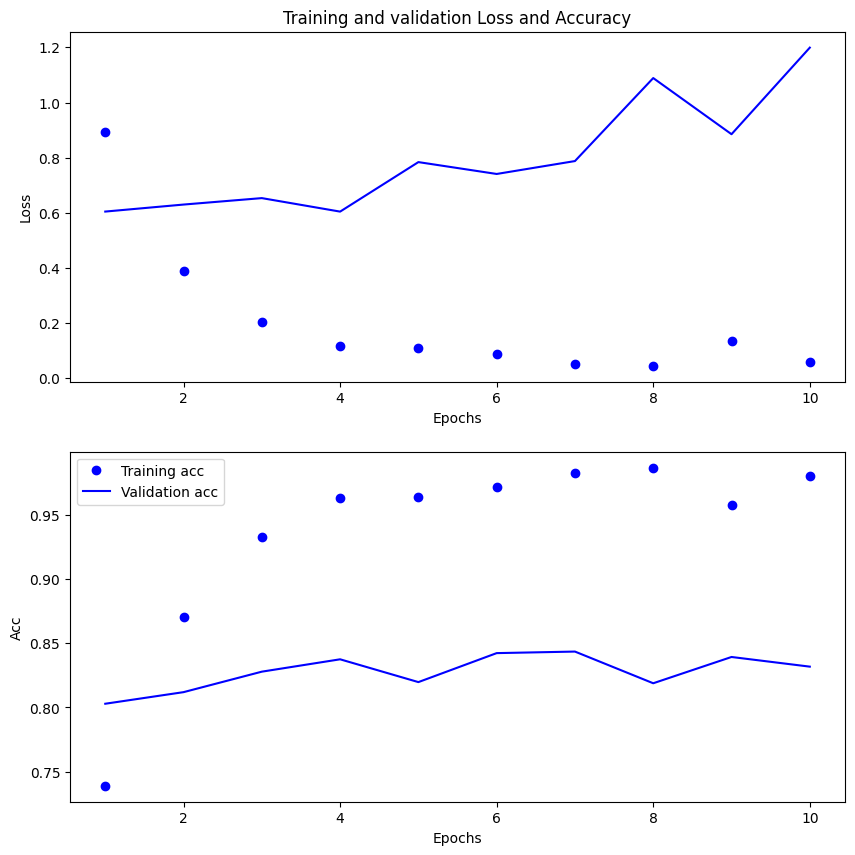

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

overfitting

## Now we will do data augmetation with prebuild models 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=.05,
    height_shift_range=.05,
    horizontal_flip=True,
    zoom_range=0.3
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(250, 250),
    batch_size=32,
    classes=CLASSES,
    class_mode='categorical'
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR, 
    classes=CLASSES,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [ ]:
sample_batch = next(train_generator)

sample_batch[0].shape


(32, 250, 250, 3)

## WEIGHTS AND BIASES

#### We will use many prebuild models for this part and check their performances using weights and biases

In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=969c93376b37c6a9da19fc3bb16e73cd560d1f30f97c5f404f09a354979a0293
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.models import Model

## Xception

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
x = base_model.output
x = Flatten()(x)
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)
# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
run = wandb.init(project='xceptionn',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 20,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "CNN",
                     
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model1.compile(optimizer, config.loss_function, metrics=['acc'])



In [ ]:
# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="xceptionn"),
]

model1.fit(train_generator,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=test_generator,
          callbacks=wandb_callbacks)

Epoch 1/20
309/309 [==============================] - ETA: 0s - loss: 20.7748 - acc: 0.6951

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 281s 874ms/step - loss: 20.7748 - acc: 0.6951 - val_loss: 13.5167 - val_acc: 0.7870
Epoch 2/20
309/309 [==============================] - ETA: 0s - loss: 17.8846 - acc: 0.7722

wandb: Adding directory to artifact (./xceptionn)... Done. 0.3s


309/309 [==============================] - 262s 845ms/step - loss: 17.8846 - acc: 0.7722 - val_loss: 15.7992 - val_acc: 0.8025
Epoch 3/20
309/309 [==============================] - ETA: 0s - loss: 17.1977 - acc: 0.8005

wandb: Adding directory to artifact (./xceptionn)... Done. 0.7s


309/309 [==============================] - 262s 847ms/step - loss: 17.1977 - acc: 0.8005 - val_loss: 16.5198 - val_acc: 0.8189
Epoch 4/20
309/309 [==============================] - ETA: 0s - loss: 15.7890 - acc: 0.8197

wandb: Adding directory to artifact (./xceptionn)... Done. 0.3s


309/309 [==============================] - 261s 844ms/step - loss: 15.7890 - acc: 0.8197 - val_loss: 16.7093 - val_acc: 0.8261
Epoch 5/20
309/309 [==============================] - ETA: 0s - loss: 15.7942 - acc: 0.8286

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 271s 875ms/step - loss: 15.7942 - acc: 0.8286 - val_loss: 30.3441 - val_acc: 0.7810
Epoch 6/20
309/309 [==============================] - ETA: 0s - loss: 14.1800 - acc: 0.8451

wandb: Adding directory to artifact (./xceptionn)... Done. 0.5s


309/309 [==============================] - 259s 838ms/step - loss: 14.1800 - acc: 0.8451 - val_loss: 19.9420 - val_acc: 0.8169
Epoch 7/20
309/309 [==============================] - ETA: 0s - loss: 14.3720 - acc: 0.8520

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 260s 840ms/step - loss: 14.3720 - acc: 0.8520 - val_loss: 19.5525 - val_acc: 0.8387
Epoch 8/20
309/309 [==============================] - ETA: 0s - loss: 13.3896 - acc: 0.8599

wandb: Adding directory to artifact (./xceptionn)... Done. 0.3s


309/309 [==============================] - 259s 837ms/step - loss: 13.3896 - acc: 0.8599 - val_loss: 18.5324 - val_acc: 0.8342
Epoch 9/20
309/309 [==============================] - ETA: 0s - loss: 13.5744 - acc: 0.8663

wandb: Adding directory to artifact (./xceptionn)... Done. 0.5s


309/309 [==============================] - 259s 837ms/step - loss: 13.5744 - acc: 0.8663 - val_loss: 21.1593 - val_acc: 0.8357
Epoch 10/20
309/309 [==============================] - ETA: 0s - loss: 15.1692 - acc: 0.8559

wandb: Adding directory to artifact (./xceptionn)... Done. 0.3s


309/309 [==============================] - 271s 877ms/step - loss: 15.1692 - acc: 0.8559 - val_loss: 19.5905 - val_acc: 0.8467
Epoch 11/20
309/309 [==============================] - ETA: 0s - loss: 13.1867 - acc: 0.8726

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 258s 834ms/step - loss: 13.1867 - acc: 0.8726 - val_loss: 18.9927 - val_acc: 0.8518
Epoch 12/20
309/309 [==============================] - ETA: 0s - loss: 12.8275 - acc: 0.8803

wandb: Adding directory to artifact (./xceptionn)... Done. 0.3s


309/309 [==============================] - 258s 836ms/step - loss: 12.8275 - acc: 0.8803 - val_loss: 21.5896 - val_acc: 0.8449
Epoch 13/20
309/309 [==============================] - ETA: 0s - loss: 12.3734 - acc: 0.8823

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 256s 828ms/step - loss: 12.3734 - acc: 0.8823 - val_loss: 20.9651 - val_acc: 0.8449
Epoch 14/20
309/309 [==============================] - ETA: 0s - loss: 12.4044 - acc: 0.8838

wandb: Adding directory to artifact (./xceptionn)... Done. 0.5s


309/309 [==============================] - 259s 838ms/step - loss: 12.4044 - acc: 0.8838 - val_loss: 27.0486 - val_acc: 0.8192
Epoch 15/20
309/309 [==============================] - ETA: 0s - loss: 12.6328 - acc: 0.8859

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 260s 840ms/step - loss: 12.6328 - acc: 0.8859 - val_loss: 22.7076 - val_acc: 0.8416
Epoch 16/20
309/309 [==============================] - ETA: 0s - loss: 10.6163 - acc: 0.8971

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 258s 836ms/step - loss: 10.6163 - acc: 0.8971 - val_loss: 31.0072 - val_acc: 0.8121
Epoch 17/20
309/309 [==============================] - ETA: 0s - loss: 11.7993 - acc: 0.8932

wandb: Adding directory to artifact (./xceptionn)... Done. 0.5s


309/309 [==============================] - 260s 842ms/step - loss: 11.7993 - acc: 0.8932 - val_loss: 23.2632 - val_acc: 0.8467
Epoch 18/20
309/309 [==============================] - ETA: 0s - loss: 12.4959 - acc: 0.8879

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 260s 842ms/step - loss: 12.4959 - acc: 0.8879 - val_loss: 26.3031 - val_acc: 0.8431
Epoch 19/20
309/309 [==============================] - ETA: 0s - loss: 11.2197 - acc: 0.9003

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 258s 836ms/step - loss: 11.2197 - acc: 0.9003 - val_loss: 21.6270 - val_acc: 0.8593
Epoch 20/20
309/309 [==============================] - ETA: 0s - loss: 10.8918 - acc: 0.9018

wandb: Adding directory to artifact (./xceptionn)... Done. 0.4s


309/309 [==============================] - 258s 834ms/step - loss: 10.8918 - acc: 0.9018 - val_loss: 25.9420 - val_acc: 0.8473


In [ ]:
loss, accuracy = model1.evaluate(test_generator)


# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'accuracy': accuracy,'loss': loss})

run.finish()

105/105 [==============================] - 30s 284ms/step - loss: 25.9420 - acc: 0.8473


#### Xception summary: Xception have a very high accuracy  but the problem is with the validation loss so to try to improvr this model we added a dense layer .

### Xception with dense layer

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)#we added a dense layer
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)
# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

model1.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
run = wandb.init(project='xception_',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 23,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "CNN",
                     
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model1.compile(optimizer, config.loss_function, metrics=['acc'])



In [ ]:
# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="xception_"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,verbose=1)
]

model1.fit(train_generator,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=test_generator,
          callbacks=wandb_callbacks)

Epoch 1/23
309/309 [==============================] - ETA: 0s - loss: 1.9941 - acc: 0.5457

wandb: Adding directory to artifact (./xception_)... Done. 1.4s


309/309 [==============================] - 275s 871ms/step - loss: 1.9941 - acc: 0.5457 - val_loss: 1.1135 - val_acc: 0.6585
Epoch 2/23
309/309 [==============================] - ETA: 0s - loss: 1.1644 - acc: 0.6415

wandb: Adding directory to artifact (./xception_)... Done. 4.5s


309/309 [==============================] - 265s 858ms/step - loss: 1.1644 - acc: 0.6415 - val_loss: 1.0451 - val_acc: 0.6866
Epoch 3/23
309/309 [==============================] - ETA: 0s - loss: 1.0967 - acc: 0.6613

wandb: Adding directory to artifact (./xception_)... Done. 1.0s


309/309 [==============================] - 258s 836ms/step - loss: 1.0967 - acc: 0.6613 - val_loss: 1.0144 - val_acc: 0.6929
Epoch 4/23
309/309 [==============================] - ETA: 0s - loss: 1.0505 - acc: 0.6693

wandb: Adding directory to artifact (./xception_)... Done. 1.1s


309/309 [==============================] - 259s 837ms/step - loss: 1.0505 - acc: 0.6693 - val_loss: 1.0659 - val_acc: 0.6696
Epoch 5/23
309/309 [==============================] - ETA: 0s - loss: 1.0222 - acc: 0.6804

wandb: Adding directory to artifact (./xception_)... Done. 1.2s


309/309 [==============================] - 259s 838ms/step - loss: 1.0222 - acc: 0.6804 - val_loss: 0.9432 - val_acc: 0.7132
Epoch 6/23
309/309 [==============================] - ETA: 0s - loss: 1.0085 - acc: 0.6904

wandb: Adding directory to artifact (./xception_)... Done. 3.7s


309/309 [==============================] - 261s 843ms/step - loss: 1.0085 - acc: 0.6904 - val_loss: 0.9453 - val_acc: 0.7437
Epoch 7/23
309/309 [==============================] - ETA: 0s - loss: 0.9993 - acc: 0.6934

wandb: Adding directory to artifact (./xception_)... Done. 1.1s


309/309 [==============================] - 261s 844ms/step - loss: 0.9993 - acc: 0.6934 - val_loss: 0.9190 - val_acc: 0.6875
Epoch 8/23
309/309 [==============================] - ETA: 0s - loss: 1.0020 - acc: 0.6941

wandb: Adding directory to artifact (./xception_)... Done. 1.1s


309/309 [==============================] - 262s 847ms/step - loss: 1.0020 - acc: 0.6941 - val_loss: 1.0816 - val_acc: 0.6274
Epoch 9/23
309/309 [==============================] - ETA: 0s - loss: 1.0065 - acc: 0.6894

wandb: Adding directory to artifact (./xception_)... Done. 3.3s


309/309 [==============================] - 276s 895ms/step - loss: 1.0065 - acc: 0.6894 - val_loss: 1.4350 - val_acc: 0.6376
Epoch 10/23
309/309 [==============================] - ETA: 0s - loss: 0.9897 - acc: 0.6950

wandb: Adding directory to artifact (./xception_)... Done. 4.4s


309/309 [==============================] - 262s 846ms/step - loss: 0.9897 - acc: 0.6950 - val_loss: 1.2145 - val_acc: 0.6687
Epoch 11/23
309/309 [==============================] - ETA: 0s - loss: 1.0443 - acc: 0.6791

wandb: Adding directory to artifact (./xception_)... Done. 1.1s


309/309 [==============================] - 261s 844ms/step - loss: 1.0443 - acc: 0.6791 - val_loss: 1.1839 - val_acc: 0.6442
Epoch 12/23
309/309 [==============================] - ETA: 0s - loss: 1.0439 - acc: 0.6857

wandb: Adding directory to artifact (./xception_)... Done. 4.3s


309/309 [==============================] - 269s 870ms/step - loss: 1.0439 - acc: 0.6857 - val_loss: 1.1176 - val_acc: 0.6872
Epoch 13/23
309/309 [==============================] - ETA: 0s - loss: 1.0236 - acc: 0.6728

wandb: Adding directory to artifact (./xception_)... Done. 3.2s


309/309 [==============================] - 264s 855ms/step - loss: 1.0236 - acc: 0.6728 - val_loss: 1.0097 - val_acc: 0.6749
Epoch 13: early stopping


In [ ]:
loss, accuracy = model1.evaluate(test_generator)


# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'accuracy': accuracy,'loss': loss})

run.finish()

105/105 [==============================] - 30s 281ms/step - loss: 1.0097 - acc: 0.6749


#### This time we got a lower accuracy than before ( ~0.67) but the validation loss is way better

## ResNet152V2

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2


In [ ]:
base_model2 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
x = base_model2.output
x = Flatten()(x)

predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model2 = Model(inputs=base_model2.input, outputs=predictions)
# Freezing pretrained layers
for layer in base_model2.layers:
    layer.trainable=False

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
run = wandb.init(project='ResNetV2',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 10,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "CNN",
                     
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model2.compile(optimizer, config.loss_function, metrics=['acc'])



In [ ]:
# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="ResNetV2"),
    EarlyStopping(monitor='val_acc', patience=5)
]

model2.fit(train_generator,
          epochs=config.epochs, 
          batch_size=config.batch_size,         
          validation_data=test_generator,
          callbacks=wandb_callbacks)

Epoch 1/10
309/309 [==============================] - ETA: 0s - loss: 36.0547 - acc: 0.6936

wandb: Adding directory to artifact (./ResNetV2)... Done. 1.3s


309/309 [==============================] - 347s 1s/step - loss: 36.0547 - acc: 0.6936 - val_loss: 33.4567 - val_acc: 0.7795
Epoch 2/10
309/309 [==============================] - ETA: 0s - loss: 32.9996 - acc: 0.7811

wandb: Adding directory to artifact (./ResNetV2)... Done. 1.3s


309/309 [==============================] - 325s 1s/step - loss: 32.9996 - acc: 0.7811 - val_loss: 29.6356 - val_acc: 0.8171
Epoch 3/10
309/309 [==============================] - ETA: 0s - loss: 30.6444 - acc: 0.8157

wandb: Adding directory to artifact (./ResNetV2)... Done. 3.0s


309/309 [==============================] - 322s 1s/step - loss: 30.6444 - acc: 0.8157 - val_loss: 36.9165 - val_acc: 0.8067
Epoch 4/10
309/309 [==============================] - ETA: 0s - loss: 29.1188 - acc: 0.8286

wandb: Adding directory to artifact (./ResNetV2)... Done. 1.2s


309/309 [==============================] - 328s 1s/step - loss: 29.1188 - acc: 0.8286 - val_loss: 35.5458 - val_acc: 0.8216
Epoch 5/10
309/309 [==============================] - ETA: 0s - loss: 26.6703 - acc: 0.8491

wandb: Adding directory to artifact (./ResNetV2)... Done. 1.7s


309/309 [==============================] - 325s 1s/step - loss: 26.6703 - acc: 0.8491 - val_loss: 37.5463 - val_acc: 0.8339
Epoch 6/10
309/309 [==============================] - ETA: 0s - loss: 26.6385 - acc: 0.8549

wandb: Adding directory to artifact (./ResNetV2)... Done. 1.9s


309/309 [==============================] - 328s 1s/step - loss: 26.6385 - acc: 0.8549 - val_loss: 41.0225 - val_acc: 0.8270
Epoch 7/10
309/309 [==============================] - ETA: 0s - loss: 25.3055 - acc: 0.8620

wandb: Adding directory to artifact (./ResNetV2)... Done. 2.9s


309/309 [==============================] - 327s 1s/step - loss: 25.3055 - acc: 0.8620 - val_loss: 50.9324 - val_acc: 0.8127
Epoch 8/10
309/309 [==============================] - ETA: 0s - loss: 26.3317 - acc: 0.8674

wandb: Adding directory to artifact (./ResNetV2)... Done. 3.5s


309/309 [==============================] - 325s 1s/step - loss: 26.3317 - acc: 0.8674 - val_loss: 43.9348 - val_acc: 0.8261
Epoch 9/10
309/309 [==============================] - ETA: 0s - loss: 26.3251 - acc: 0.8732

wandb: Adding directory to artifact (./ResNetV2)... Done. 1.3s


309/309 [==============================] - 340s 1s/step - loss: 26.3251 - acc: 0.8732 - val_loss: 48.7241 - val_acc: 0.8285
Epoch 10/10
309/309 [==============================] - ETA: 0s - loss: 23.7290 - acc: 0.8830

wandb: Adding directory to artifact (./ResNetV2)... Done. 1.2s


309/309 [==============================] - 336s 1s/step - loss: 23.7290 - acc: 0.8830 - val_loss: 53.1037 - val_acc: 0.8148


In [ ]:
loss, accuracy = model2.evaluate(test_generator)


# With wandb.log, we can easily pass in metrics as key-value pairs.
#wandb.log({'accuracy': accuracy,'loss': loss})

run.finish()

105/105 [==============================] - 38s 363ms/step - loss: 53.1037 - acc: 0.8148


#### Resnet summary

resnet  have a high accurace approximately 85
but the problem is that the validation loss is too high

which means that the model is overfitting

It is a bad mode overall




## VGG16

In [ ]:
 from tensorflow.keras.applications import VGG16


In [ ]:
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

x = base_model2.output
x = Flatten()(x)
#x = Dense(100, activation='relu')(x)
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model3 = Model(inputs=base_model2.input, outputs=predictions)
# Freezing pretrained layers
for layer in base_model2.layers:
    layer.trainable=False

model3.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                              

In [ ]:
run = wandb.init(project='VGG16',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 15,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "CNN",
                     
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model3.compile(optimizer, config.loss_function, metrics=['acc'])

In [ ]:
# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="VGG16"),
]

model3.fit(train_generator,
          epochs=config.epochs, 
          batch_size=config.batch_size,         
          validation_data=test_generator,
          callbacks=wandb_callbacks)

Epoch 1/15
309/309 [==============================] - ETA: 0s - loss: 4.4730 - acc: 0.4720

wandb: Adding directory to artifact (./VGG16)... Done. 0.3s


309/309 [==============================] - 258s 813ms/step - loss: 4.4730 - acc: 0.4720 - val_loss: 3.4620 - val_acc: 0.6020
Epoch 2/15
309/309 [==============================] - ETA: 0s - loss: 3.7069 - acc: 0.5756

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 245s 792ms/step - loss: 3.7069 - acc: 0.5756 - val_loss: 3.7762 - val_acc: 0.6044
Epoch 3/15
309/309 [==============================] - ETA: 0s - loss: 3.6785 - acc: 0.6104

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 244s 791ms/step - loss: 3.6785 - acc: 0.6104 - val_loss: 4.0256 - val_acc: 0.6286
Epoch 4/15
309/309 [==============================] - ETA: 0s - loss: 3.6912 - acc: 0.6267

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 254s 821ms/step - loss: 3.6912 - acc: 0.6267 - val_loss: 4.1559 - val_acc: 0.6262
Epoch 5/15
309/309 [==============================] - ETA: 0s - loss: 3.4914 - acc: 0.6487

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 244s 790ms/step - loss: 3.4914 - acc: 0.6487 - val_loss: 4.2922 - val_acc: 0.6367
Epoch 6/15
309/309 [==============================] - ETA: 0s - loss: 3.7010 - acc: 0.6591

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 244s 790ms/step - loss: 3.7010 - acc: 0.6591 - val_loss: 4.5120 - val_acc: 0.6463
Epoch 7/15
309/309 [==============================] - ETA: 0s - loss: 3.4832 - acc: 0.6737

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 244s 789ms/step - loss: 3.4832 - acc: 0.6737 - val_loss: 4.1703 - val_acc: 0.6519
Epoch 8/15
309/309 [==============================] - ETA: 0s - loss: 3.4678 - acc: 0.6811

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 242s 785ms/step - loss: 3.4678 - acc: 0.6811 - val_loss: 4.4970 - val_acc: 0.6651
Epoch 9/15
309/309 [==============================] - ETA: 0s - loss: 3.6436 - acc: 0.6892

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 243s 786ms/step - loss: 3.6436 - acc: 0.6892 - val_loss: 4.8893 - val_acc: 0.6439
Epoch 10/15
309/309 [==============================] - ETA: 0s - loss: 3.8904 - acc: 0.6827

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 244s 788ms/step - loss: 3.8904 - acc: 0.6827 - val_loss: 4.4289 - val_acc: 0.6719
Epoch 11/15
309/309 [==============================] - ETA: 0s - loss: 3.4252 - acc: 0.7043

wandb: Adding directory to artifact (./VGG16)... Done. 0.3s


309/309 [==============================] - 245s 791ms/step - loss: 3.4252 - acc: 0.7043 - val_loss: 4.5547 - val_acc: 0.6713
Epoch 12/15
309/309 [==============================] - ETA: 0s - loss: 3.6385 - acc: 0.7020

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 273s 882ms/step - loss: 3.6385 - acc: 0.7020 - val_loss: 4.5296 - val_acc: 0.6779
Epoch 13/15
309/309 [==============================] - ETA: 0s - loss: 3.5231 - acc: 0.7131

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 245s 792ms/step - loss: 3.5231 - acc: 0.7131 - val_loss: 4.4966 - val_acc: 0.6899
Epoch 14/15
309/309 [==============================] - ETA: 0s - loss: 3.4456 - acc: 0.7201

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 246s 795ms/step - loss: 3.4456 - acc: 0.7201 - val_loss: 5.3065 - val_acc: 0.6758
Epoch 15/15
309/309 [==============================] - ETA: 0s - loss: 3.4221 - acc: 0.7215

wandb: Adding directory to artifact (./VGG16)... Done. 0.2s


309/309 [==============================] - 244s 790ms/step - loss: 3.4221 - acc: 0.7215 - val_loss: 4.9260 - val_acc: 0.6836


In [ ]:
loss, accuracy = model3.evaluate(test_generator)


# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'accuracy': accuracy,'loss': loss})

run.finish()

105/105 [==============================] - 30s 283ms/step - loss: 4.9260 - acc: 0.6836


#### VGG16 summary 
we can see that the loss is going down and the accuracy is increasing with every epoch

We can also see that the validation accuracy is high

and the loss is better than resnet model

Also it is not overfitting since the test accuracy is close to the train accuracy




In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


## InceptionResNetV2

In [ ]:
base_model2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

x = base_model2.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model4 = Model(inputs=base_model2.input, outputs=predictions)
# Freezing pretrained layers
for layer in base_model2.layers:
    layer.trainable=False

model4.summary()

219055592/219055592 [==============================] - 8s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 124, 32  96         ['conv2d_4[0][0]']               
 alization)              

In [ ]:
run = wandb.init(project='inception',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 15,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "CNN",
                     
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model4.compile(optimizer, config.loss_function, metrics=['acc'])



In [ ]:
# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="iception"),
]

model4.fit(train_generator,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=test_generator,
          callbacks=wandb_callbacks)

Epoch 1/15
309/309 [==============================] - ETA: 0s - loss: 2.0437 - acc: 0.5223

wandb: Adding directory to artifact (./iception)... Done. 1.1s


309/309 [==============================] - 332s 1s/step - loss: 2.0437 - acc: 0.5223 - val_loss: 1.0962 - val_acc: 0.6830
Epoch 2/15
309/309 [==============================] - ETA: 0s - loss: 1.2743 - acc: 0.5771

wandb: Adding directory to artifact (./iception)... Done. 1.6s


309/309 [==============================] - 320s 1s/step - loss: 1.2743 - acc: 0.5771 - val_loss: 1.0488 - val_acc: 0.6887
Epoch 3/15
309/309 [==============================] - ETA: 0s - loss: 1.2208 - acc: 0.6111

wandb: Adding directory to artifact (./iception)... Done. 1.0s


309/309 [==============================] - 312s 1s/step - loss: 1.2208 - acc: 0.6111 - val_loss: 1.2528 - val_acc: 0.5961
Epoch 4/15
309/309 [==============================] - ETA: 0s - loss: 1.1659 - acc: 0.6333

wandb: Adding directory to artifact (./iception)... Done. 2.3s


309/309 [==============================] - 313s 1s/step - loss: 1.1659 - acc: 0.6333 - val_loss: 1.1114 - val_acc: 0.6923
Epoch 5/15
309/309 [==============================] - ETA: 0s - loss: 1.1372 - acc: 0.6605

wandb: Adding directory to artifact (./iception)... Done. 1.1s


309/309 [==============================] - 329s 1s/step - loss: 1.1372 - acc: 0.6605 - val_loss: 1.0168 - val_acc: 0.6976
Epoch 6/15
309/309 [==============================] - ETA: 0s - loss: 1.1048 - acc: 0.6590

wandb: Adding directory to artifact (./iception)... Done. 1.1s


309/309 [==============================] - 313s 1s/step - loss: 1.1048 - acc: 0.6590 - val_loss: 1.0257 - val_acc: 0.6764
Epoch 7/15
309/309 [==============================] - ETA: 0s - loss: 1.1556 - acc: 0.6489

wandb: Adding directory to artifact (./iception)... Done. 1.1s


309/309 [==============================] - 313s 1s/step - loss: 1.1556 - acc: 0.6489 - val_loss: 0.9661 - val_acc: 0.7015
Epoch 8/15
309/309 [==============================] - ETA: 0s - loss: 1.1056 - acc: 0.6634

wandb: Adding directory to artifact (./iception)... Done. 2.4s


309/309 [==============================] - 315s 1s/step - loss: 1.1056 - acc: 0.6634 - val_loss: 1.0251 - val_acc: 0.6845
Epoch 9/15
309/309 [==============================] - ETA: 0s - loss: 1.0637 - acc: 0.6734

wandb: Adding directory to artifact (./iception)... Done. 1.3s


309/309 [==============================] - 311s 1s/step - loss: 1.0637 - acc: 0.6734 - val_loss: 1.0468 - val_acc: 0.6881
Epoch 10/15
309/309 [==============================] - ETA: 0s - loss: 1.1879 - acc: 0.6379

wandb: Adding directory to artifact (./iception)... Done. 1.2s


309/309 [==============================] - 322s 1s/step - loss: 1.1879 - acc: 0.6379 - val_loss: 1.1083 - val_acc: 0.6367
Epoch 11/15
309/309 [==============================] - ETA: 0s - loss: 1.1219 - acc: 0.6587

wandb: Adding directory to artifact (./iception)... Done. 1.7s


309/309 [==============================] - 325s 1s/step - loss: 1.1219 - acc: 0.6587 - val_loss: 1.3440 - val_acc: 0.6337
Epoch 12/15
309/309 [==============================] - ETA: 0s - loss: 1.1709 - acc: 0.6471

wandb: Adding directory to artifact (./iception)... Done. 2.0s


309/309 [==============================] - 314s 1s/step - loss: 1.1709 - acc: 0.6471 - val_loss: 1.1586 - val_acc: 0.6917
Epoch 13/15
309/309 [==============================] - ETA: 0s - loss: 1.1239 - acc: 0.6681

wandb: Adding directory to artifact (./iception)... Done. 1.3s


309/309 [==============================] - 307s 994ms/step - loss: 1.1239 - acc: 0.6681 - val_loss: 1.0549 - val_acc: 0.7075
Epoch 14/15
309/309 [==============================] - ETA: 0s - loss: 1.0758 - acc: 0.6791

wandb: Adding directory to artifact (./iception)... Done. 1.3s


309/309 [==============================] - 351s 1s/step - loss: 1.0758 - acc: 0.6791 - val_loss: 1.2667 - val_acc: 0.6430
Epoch 15/15
309/309 [==============================] - ETA: 0s - loss: 1.1081 - acc: 0.6586

wandb: Adding directory to artifact (./iception)... Done. 2.1s


309/309 [==============================] - 332s 1s/step - loss: 1.1081 - acc: 0.6586 - val_loss: 1.0241 - val_acc: 0.6997


In [ ]:
loss, accuracy = model4.evaluate(test_generator)


# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'accuracy': accuracy,'loss': loss})

run.finish()

105/105 [==============================] - 31s 289ms/step - loss: 1.0241 - acc: 0.6997



#### Inception net model
we can see that the loss is going down and the accuracy is increasing with every epoch

We can also see that the validation accuracy is going up with the training accuracy 

The loss is also going down it is approximately 1  it is better than vgg16 loss

Also it is not overfitting since the test accuracy is close to the train accuracy and the validation loss is also low

inceptionNet did better than the other prebuild models in terms of accuracy and loss




## FINAL MODEL

### InceptionResNetV2

In [ ]:
base_model2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

x = base_model2.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model4 = Model(inputs=base_model2.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model2.layers:
    layer.trainable=False
    
optimizer = Adam()
model4.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs = 15

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_incept2.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,verbose=1)
]
BATCH_SIZE=32
history = model4.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=test_generator,
        verbose = 1,
        validation_steps=test_generator.samples // BATCH_SIZE)

Epoch 1/15
308/308 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.7109
Epoch 1: val_loss improved from inf to 0.57211, saving model to model_incept2.h5
308/308 [==============================] - 255s 790ms/step - loss: 0.9620 - accuracy: 0.7109 - val_loss: 0.5721 - val_accuracy: 0.8062
Epoch 2/15
308/308 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.7966
Epoch 2: val_loss did not improve from 0.57211
308/308 [==============================] - 224s 728ms/step - loss: 0.6213 - accuracy: 0.7966 - val_loss: 0.5957 - val_accuracy: 0.7999
Epoch 3/15
308/308 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.8131
Epoch 3: val_loss improved from 0.57211 to 0.55710, saving model to model_incept2.h5
308/308 [==============================] - 237s 771ms/step - loss: 0.5737 - accuracy: 0.8131 - val_loss: 0.5571 - val_accuracy: 0.8272
Epoch 4/15
308/308 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.828

In [ ]:
model4.evaluate_generator(
    test_generator, 
    steps = test_generator.n // 32, 
    verbose = 1
)

104/104 [==============================] - 29s 279ms/step - loss: 0.5635 - accuracy: 0.8395


[0.563451886177063, 0.8395432829856873]

Thats the best model we got with a test accuracy of 84%

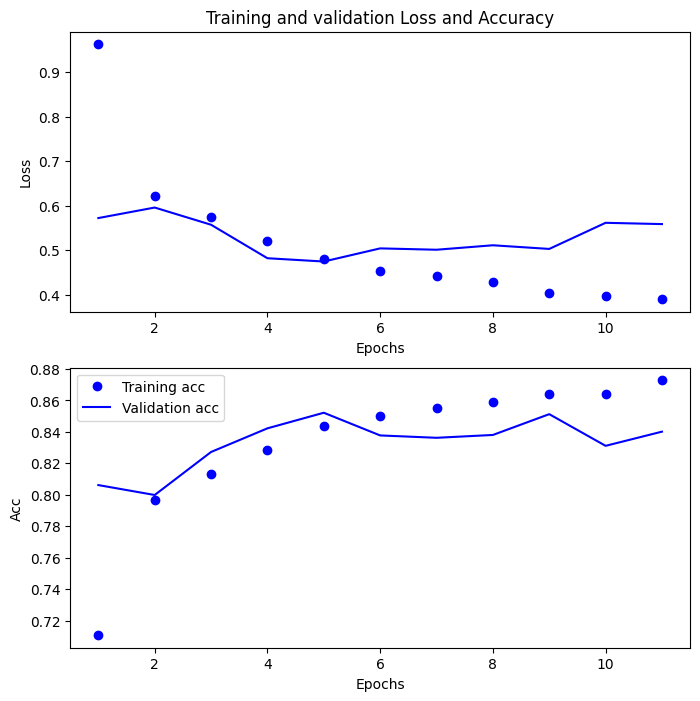

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# Assigning label names to the corresponding indexes
labels = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [ ]:
# Loading images and their predictions 
import PIL
prediction = []
original = []
image = []
count = 0
path_eval = "/content/evaluation"
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        #code to open the image
        img= PIL.Image.open(os.path.join(path_eval, i, item))
        #resizing the image to (256,256)
        img = img.resize((250,250))
        #appending image to the image list
        image.append(img)
        #converting image to array
        img = np.asarray(img, dtype= np.float32)
        #normalizing the image
        img = img / 255
        #reshaping the image in to a 4D array
        img = img.reshape(-1,250,250,3)
        #making prediction of the model
        predict = model.predict(img)
        #getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        #appending the predicted class to the list
        prediction.append(labels[predict])
        #appending original class to the list
        original.append(i)

1/1 [==============================] - 0s 40ms/step


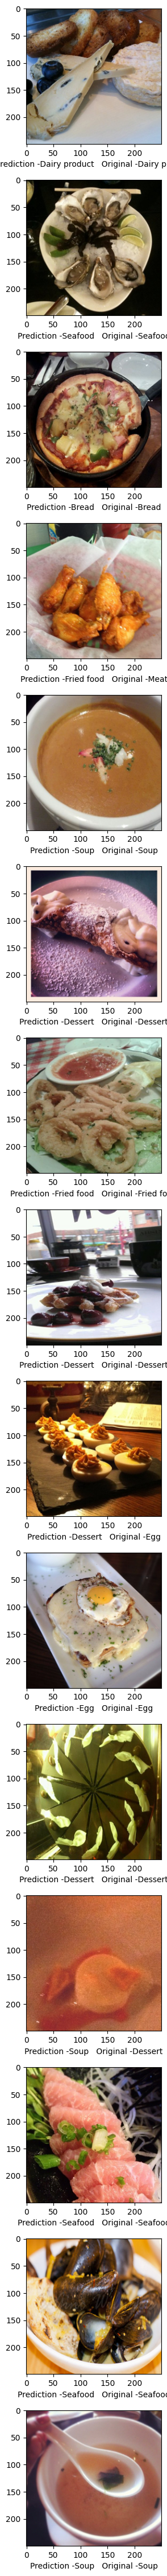

In [ ]:
# Visualizing the results
fig=plt.figure(figsize = (60,60))
for i in range(15):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()